<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_15_Convolution_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import the libraries
import numpy as np

import torch
import torch.nn as nn

# For Image Processing
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

#Mean & Max Pooling

## Create a Max Pool Instance

In [2]:
# create a pool class instance with the following parameters
poolSize = 3
stride = 3

# Create the instance
p2 = nn.MaxPool2d(poolSize, stride=3)
p3 = nn.MaxPool3d(poolSize, stride=3)

print(p2)
print(p3)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [3]:
# Create an image and apply max pooling

# 2D image
img2 = torch.randn(1,1,30,30)

# 3D image
img3 = torch.randn(1,3,30,30)

# Check all the combinations of image and maxpool dimensionality
img2Pool2 = p2(img2)
print(f"2D image, 2D maxpool: {img2Pool2.shape}")
print()

# 2D image cannot be used in 3d pooling operation: It is impossible
# img2Pool3 = p3(img2)
# print(f"2D image, 3D maxpool: {img2Pool3.shape}")
# print()

img3Pool2 = p2(img3)
print(f"3D image, 2D maxpool: {img3Pool2.shape}")
print()

img3Pool3 = p3(img3)
print(f"3D image, 3D maxpool: {img3Pool3.shape}")
print()

2D image, 2D maxpool: torch.Size([1, 1, 10, 10])

3D image, 2D maxpool: torch.Size([1, 3, 10, 10])

3D image, 3D maxpool: torch.Size([1, 1, 10, 10])



## Create a CNN

In [4]:
# Construct a simple CNN architecture
littlenet = nn.Sequential(

    # The convolution-pool block
    nn.Conv2d(3,10,5,3,2),  # Convolution layer
    nn.ReLU(),              # The activation Function
    nn.AvgPool3d(3,3),      # Average pooling

    # The Feed-Forward Block
    nn.Flatten(),           # Vectorize to het from image to linear
    nn.Linear(588,1),       # Fully-Connected linear layer
    nn.Sigmoid()            # Output Activation
    )

In [5]:
# Test it with some data
img = torch.rand(1,3,128,128)
littlenet(img)
# A dummy number, not trained model

tensor([[0.5082]], grad_fn=<SigmoidBackward0>)

# Image Transforms

In [7]:
# Import the Dataset: CIFAR with 10 categories
cdata = torchvision.datasets.CIFAR10(root="cifar10", download=True)

print(cdata)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


In [8]:
# Check the shape of the dataset
print(cdata.data.shape)

(50000, 32, 32, 3)


In [9]:
# Check the unique categories
print(cdata.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
# .targets is a list of targets converted to ints
# print(cdata.targets)
print(len(cdata.targets))

50000


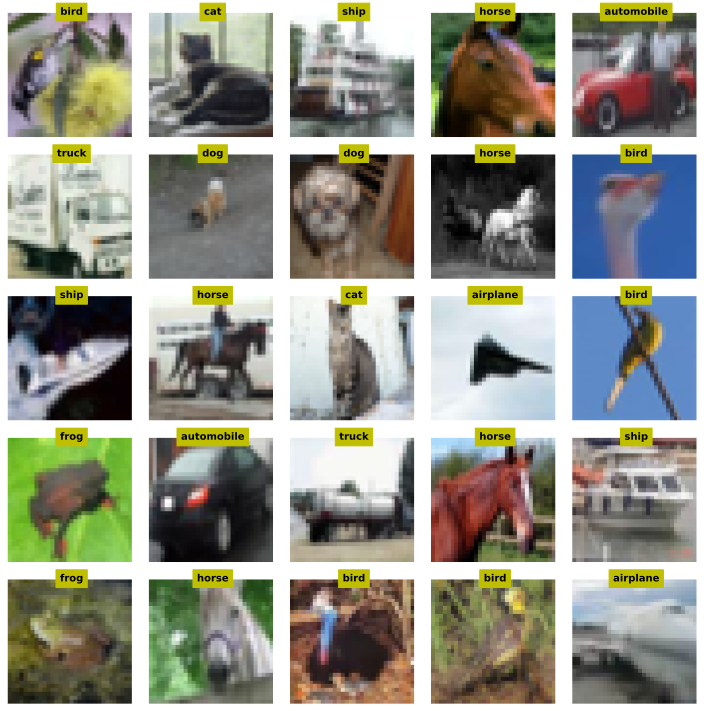

In [14]:
# Lets check a few random images
fig,axs = plt.subplots(5,5,figsize=(10,10))

for ax in axs.flatten():

    # Grab a random picture
    randidx = np.random.choice(len(cdata.targets))

    # Extract the values of that image
    pic = cdata.data[randidx,:,:,:]

    # Get its label
    label = cdata.classes[cdata.targets[randidx]]

    # Plot
    ax.imshow(pic)
    ax.text(16,0,label,ha="center", fontweight="bold", color="k",backgroundcolor="y")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Apply Transformation

In [15]:
# T.Compose object gathers together a bunch of transformations, putting them in order in one object
Ts = T.Compose([
    T.ToTensor(),  # Convert to Pytorch tensor from numpy and pixels 0-1 (normalizing the data)
    T.Resize(32*4),  # Input 32*4: increase the resulution by a factor of 4
    T.Grayscale(num_output_channels=1)  # convert into gray scale
    ])

# Include the transform into the dataset
cdata.transform = Ts

# If you wanna apply the transformation when loading the data:
# cdata = torchvision.datasets.CIFAR10(root="cifar10", download=True, transform=Ts)

# Adding a transform does not change the raw image data
# Transformations are only applied when necessary
print(cdata.data[123,:,:,:].shape)

(32, 32, 3)


In [18]:
# Now apply the transform

# Option 1: Apply the transform externally to an image
img1 = Ts(cdata.data[123,:,:,:])

# Option 2: Use the embedded transform
img2 = cdata.transform(cdata.data[123,:,:,:])

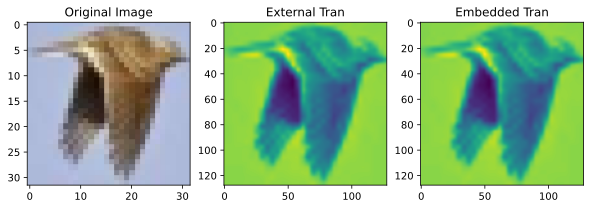

In [22]:
# Plot to see the difference
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(cdata.data[123,:,:,:])
ax[0].set_title("Original Image")
ax[1].imshow(torch.squeeze(img1))
ax[1].set_title("External Tran")
ax[2].imshow(torch.squeeze(img2))
ax[2].set_title("Embedded Tran")

plt.show()

In [26]:
# Range of pixel values to double check transformation on normalization 0-1
print(torch.min(img1), torch.max(img1))

tensor(0.0655) tensor(0.8671)


# Custom DataLoaders

In [33]:
# Step 1: Import the MNIST Dataset
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

# Extract only the first 8 images
labels = data[:8,0]
data = data[:8,1:]

# Normalize 0-1
dataNorm = data/np.max(data)

# Reshape to 2d
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

# Check the sizes
print(dataNorm.shape)
print(labels.shape)

(8, 1, 28, 28)
(8,)


In [34]:
# Step 2: Convert the data into Torch Tensor Format
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

In [35]:
dataT[1,:,:,:].shape

torch.Size([1, 28, 28])

## Customed DataSet Class

In [ ]:
# Custom dataset class is modeled after the official class in Pytorch
# ??torch.utils.data.TensorDataset